[origin url](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import os

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

In [2]:
device = torch.device(   'cuda' if torch.cuda.is_available() else 'cpu'   )

In [3]:
device

device(type='cuda')

## Importing the Dataset

In [4]:
class SubsetSC(SPEECHCOMMANDS):
    
    def __init__(self, subset):
        super(SubsetSC, self).__init__('./', download=True)
        
        def load_list(filename):
            print('root path is: ', self._path)
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip()))  for line in fileobj]
            
        if subset == 'validation':
            self._walker = load_list('validation_list.txt')
        elif subset == 'testing':
            self._walker = load_list('testing_list.txt')
        elif subset == 'training':
            excludes = load_list('validation_list.txt') + load_list('testing_list.txt')
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [5]:
# create training and testing split of the data. we do not use validation in this tutorial.
train_set = SubsetSC('training')
test_set = SubsetSC('testing')

root path is:  ./SpeechCommands/speech_commands_v0.02
root path is:  ./SpeechCommands/speech_commands_v0.02
root path is:  ./SpeechCommands/speech_commands_v0.02


In [6]:
# A data point in the Speechcommands dataset is a tuple made of 
# 1. waveform(the audio signal), 波形(音频信号)
# 2. the sample rate, 采样率
# 3. the utterance(label), 发声（标签）: 既waveform是音频信号-模型输入 the utterance是模型输出，既预测值。
# 4. the ID of the speaker, 
# 5. the number of the utterance. 发声是数量
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [7]:
f'shape of waveform: {waveform.size()}'
f'sample rate of waveform: {sample_rate}'

'sample rate of waveform: 16000'

In [8]:
waveform

tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])

In [9]:
waveform.shape

torch.Size([1, 16000])

In [10]:
sample_rate, label, speaker_id, utterance_number

(16000, 'backward', '0165e0e8', 0)

In [15]:
waveform.shape

torch.Size([1, 16000])

In [14]:
waveform.t().shape

torch.Size([16000, 1])

In [16]:
waveform

tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]])

In [17]:
waveform.t()

tensor([[-0.0658],
        [-0.0709],
        [-0.0753],
        ...,
        [-0.0700],
        [-0.0731],
        [-0.0704]])

In [19]:
sample_rate

16000

In [20]:
ipd.Audio(waveform, rate=sample_rate)

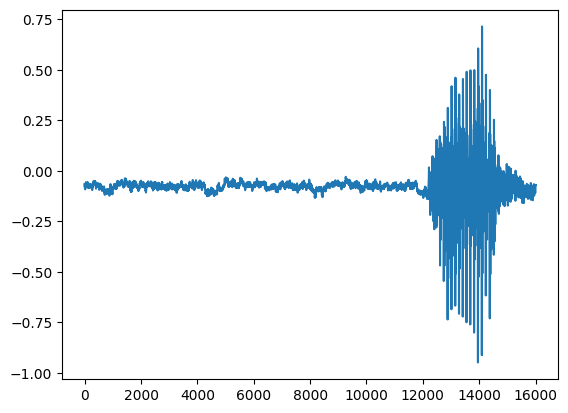

In [18]:
plt.plot(waveform.t().numpy())

In [14]:
train_set[1][1:]

(16000, 'backward', '017c4098', 0)

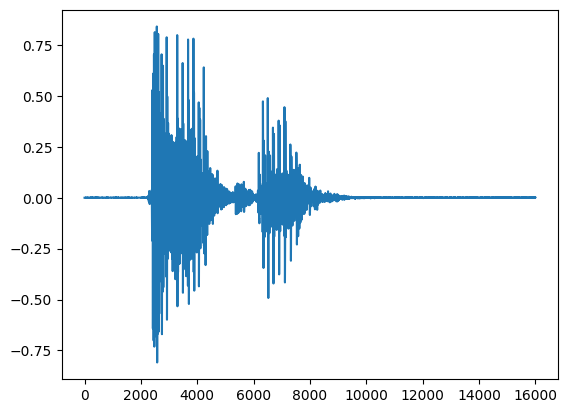

In [15]:
plt.plot(train_set[1][0].t().numpy())

In [16]:
train_set.__len__()

84843

In [17]:
# let's find the list of labels available in the dataset.
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [18]:
str(labels)

"['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']"

In [19]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first, rate=sample_rate)

In [20]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

> This is a good place to apply transformations to the data. <br>
> For the waveform, we downsample the audio for faster processing without losing too much of the classification power.<br>

> 在不损失大部分分类能力的情况下， 降采样为了更快的处理速度

> we don't need to apply other transformations here.<br>
> 我们不需要做其他的数据转换.<br>

> it is common for some dataset though to have to reduce the number of channel's (say from stereo to mono) <br>
> by either talking the mean along the channel dimension, or simply keeping only one of the chanels.<br>
> Since SpeechCommands uses a single channel for audio, this is not needed here.

> 通常是对**通道进行平均或者减少一个通道**<br>
> 但由于SpeechCommands是单通道音频，因此这里不需要转换.

In [21]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second, rate=sample_rate)

In [22]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform_second)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

> 下采样后，我们依然听的清楚

> we are encoding each word using its index in the list of labels.

In [23]:
def label_to_index(word):
    # return the position of the word in labels.
    return torch.tensor(labels.index(word))

In [24]:
def index_to_label(index):
    return labels[index]

> test

In [25]:
word_start = 'yes'
index = label_to_index(word_start)
word_recovered = index_to_label(index)

In [26]:
word_start, index, word_recovered

('yes', tensor(33), 'yes')

> 批量数据：[waveform, utterances].

In [27]:
def pad_sequence(batch):
    # make all tensor in a batch the same length by padding with zero.
    # t()的原因： 转为列向量。向量默认为列向量.
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [28]:
def collate_fn(batch):
    # A data tuple has the form.
    # waveform, sample_rate, label, speaker_id, utterance_number
    
    tensors, targets = [], []
    
    # gather in lists, and encode labels as indices.
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
        
    # group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    
    return tensors, targets

In [29]:
batch_size = 256
num_workers = 1
pin_memory = True

In [30]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_fn,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory,
                                          )

In [31]:
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=False,
                                          collate_fn=collate_fn,
                                          num_workers=num_workers,
                                          pin_memory=pin_memory
                                         )

## Define the network

In [32]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [33]:
transformed.shape

torch.Size([1, 8000])

In [34]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))

In [35]:
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [36]:
def count_parameters(model):
    return sum(  p.numel() for p in model.parameters() if p.requires_grad   )

In [37]:
n = count_parameters(model)

In [38]:
f'number of parameters: {n}'

'number of parameters: 26915'

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
# 学习率调度器: 每间隔20epochs 学习率降低0.1
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

## Training and Tesing the Network

In [40]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [41]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

> 每十个epochs降低一次学习率

In [42]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.842686
Train Epoch: 1 [5120/84843 (6%)]	Loss: 2.991600
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.603924
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.163254
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.150758
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.070541
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.731512
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.702656
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.483458
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.332084
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.406551
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.372846
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.203413
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.179306
Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.088093
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.035460
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.068148

Test Epoch: 1	Accuracy: 5396/11005 (49%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.045842
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.911177
Train Epoch: 2 [10240

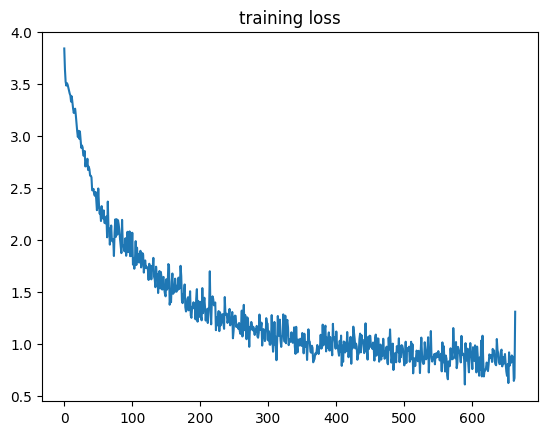

In [43]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");